In [35]:
# Install required packages
%pip install matplotlib numpy pandas torch


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Graph Attention Auto-Encoders

In [38]:
class GATE(nn.Module):
    def __init__(self, in_dimension, hidden_dims, embedding_size):
        super(GATE, self).__init__()
        all_dims = [in_dimension] + hidden_dims + [embedding_size]
        self.n_layers = len(all_dims) - 1

        # Định nghĩa các trọng số W cho các lớp encoder/decoder
        self.W = nn.ModuleList([
            nn.Linear(all_dims[i], all_dims[i+1]) for i in range(self.n_layers)
        ])

        # Định nghĩa các vector v cho cơ chế attention
        self.v = nn.ParameterList()
        for i in range(self.n_layers):
            # Mỗi lớp attention có 2 vector v
            v_layer = nn.ParameterDict({
                '0': nn.Parameter(torch.randn(all_dims[i+1], 1)),
                '1': nn.Parameter(torch.randn(all_dims[i+1], 1))
            })
            self.v.append(v_layer)

    def _encoder(self, A, H, layer_idx):
        H = self.W[layer_idx](H)
        # Tính toán ma trận attention C
        C = self.graph_attention_layer(A, H, self.v[layer_idx])
        # Áp dụng attention
        return torch.sparse.mm(C, H), C

    def _decoder(self, H, C, layer_idx):
        # Nhân với ma trận trọng số chuyển vị
        # F.linear(input, weight.T) tương đương với input @ weight
        H = F.linear(H, self.W[layer_idx].weight.t())
        # Áp dụng lại attention C từ encoder
        return torch.sparse.mm(C, H)

    def graph_attention_layer(self, A, M, v):
        # A phải là một sparse tensor
        # M là ma trận đặc trưng sau khi qua lớp Linear
        # Ensure A is coalesced before accessing indices
        A = A.coalesce()
        
        with torch.no_grad():
            f1 = M @ v['0']
            f2 = M @ v['1']
            logits_indices = A.indices()
            logits_values = A.values() * (f1.squeeze(1)[A.indices()[0]] + f2.squeeze(1)[A.indices()[1]])
            logits_uncoalesced = torch.sparse_coo_tensor(logits_indices, logits_values, A.shape)
            logits = logits_uncoalesced.coalesce()

        # Sử dụng sigmoid như trong code gốc, thay vì LeakyReLU như trong paper GAT
        unnormalized_attentions = torch.sparse_coo_tensor(logits.indices(), torch.sigmoid(logits.values()), logits.shape)
        
        # Chuẩn hóa bằng sparse_softmax
        attentions = torch.sparse.softmax(unnormalized_attentions, dim=1)
        return attentions

    def forward(self, A, X):
        # A phải là một sparse tensor, X là dense tensor
        
        # --- Encoder ---
        H = X
        attention_matrices = [] # Lưu lại các ma trận attention
        for i in range(self.n_layers):
            H, C = self._encoder(A, H, i)
            attention_matrices.append(C)
        
        # H cuối cùng là final node representations
        final_H = H

        # --- Decoder ---
        # Chạy ngược và sử dụng lại các ma trận attention đã lưu
        for i in range(self.n_layers - 1, -1, -1):
            C = attention_matrices[i]
            H = self._decoder(H, C, i)
        
        X_reconstructed = H

        return X_reconstructed, final_H

In [39]:
def gate_loss_function(X_reconstructed, X_original, H_final, R_indices, S_indices, lambda_):
    """
    Hàm loss cho mô hình GATE, được chuyển đổi từ code TensorFlow.
    """
    # 1. Feature reconstruction loss (Tương đương tf.sqrt(tf.reduce_sum...))
    # Đây là Frobenius norm, torch.linalg.norm là cách tính hiệu quả.
    features_loss = torch.linalg.norm(X_original - X_reconstructed)

    # 2. Structure reconstruction loss (Tương đương -tf.log(tf.sigmoid(...)))
    # Lấy embeddings của các nút tương ứng với các cạnh
    S_emb = H_final[S_indices]
    R_emb = H_final[R_indices]
    
    # Tính tích vô hướng để ra score cho mỗi cạnh
    positive_scores = torch.sum(S_emb * R_emb, dim=-1)
    
    # Sử dụng F.binary_cross_entropy_with_logits ổn định hơn về mặt số học
    # so với việc tự tính -log(sigmoid(x)).
    # Nó tính loss cho các cạnh có thật (positive samples), mục tiêu là nhãn 1.
    structure_loss = F.binary_cross_entropy_with_logits(
        positive_scores, 
        torch.ones_like(positive_scores),
        reduction='sum'
    )
    
    # Total loss
    total_loss = features_loss + lambda_ * structure_loss
    return total_loss

preset parameter

In [40]:
dataset = "dataset2"
lnc_mi = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_mi.csv', index_col='0').values
mi_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/mi_di.csv', index_col='0').values
lnc_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_di.csv', index_col='0').values
L_num = lnc_mi.shape[0]
D_num = mi_di.shape[1]
M_num = mi_di.shape[0]
print(f"{L_num} --- {D_num} --- {M_num}")

665 --- 316 --- 295


In [41]:
A = np.load('./our_dataset/' + dataset + '/A/A_1_1.npy')
folds = 5
in_dimension = A.shape[1]
embedding_dimension = 1024
learn_rate = 1e-4
weight_decay = 1e-5
n_epochs = 100
network_num = 1
hidden_dimension = []
lambda_param = 1

In [42]:
print("Start training GATE")
rds = []
res = []
for fold in range(folds):
    d = []
    e = []
    for i in range(network_num):
        epoch = 0
        # A = torch.Tensor(np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy'))
        A_numpy = np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy')
        
        # Tạo ma trận đặc trưng (dense tensor) để làm input features
        # Đổi tên A -> A_features để code rõ ràng hơn
        A_features = torch.Tensor(A_numpy)

        edge_indices = torch.from_numpy(np.vstack(A_numpy.nonzero()))
        edge_values = torch.ones(edge_indices.shape[1], dtype=torch.float32)
        A_sparse = torch.sparse_coo_tensor(edge_indices, edge_values, A.shape).coalesce()
        source_nodes_indices = edge_indices[0] # Nút nguồn (S)
        target_nodes_indices = edge_indices[1] # Nút đích (R)


        # Thay đổi 1: Sử dụng mô hình VGAE thay vì GraphConvolution
        model = GATE(in_dimension, hidden_dimension, embedding_dimension) # <--- THAY ĐỔI
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
    

        while epoch < n_epochs:
            model.train()
            optimizer.zero_grad()
        

            reconstructed_A, final_embeddings = model(A_sparse, A_features)
            
            # Thay đổi 4: Sử dụng hàm loss của GATE
            loss = gate_loss_function(reconstructed_A, A_features, final_embeddings, 
                                      target_nodes_indices, source_nodes_indices, lambda_param)
            
            loss.backward()
            optimizer.step()
            epoch += 1
            
        model.eval()
        with torch.no_grad():
            # Forward pass khi eval cũng trả về 3 giá trị
            rd, re = model(A_sparse, A_features) # <--- THAY ĐỔI
            d.append(rd)
            
            # Thay đổi 5: Lưu 'mu' làm vector biểu diễn tiềm ẩn
            e.append(re) # <--- THAY ĐỔI (thay 're' bằng 'mu')
            
        # Tên biến loss đã được cập nhật ở trên
        print(f"The layer {fold + 1} variational graph auto-encoder loss is {loss.detach().cpu().item()}")
    
    res.append(e)
    rds.append(d)

Start training GATE
The layer 1 variational graph auto-encoder loss is 187.24618530273438
The layer 2 variational graph auto-encoder loss is 187.9795684814453
The layer 3 variational graph auto-encoder loss is 178.19207763671875
The layer 4 variational graph auto-encoder loss is 194.86154174804688
The layer 5 variational graph auto-encoder loss is 192.660888671875


Save the results

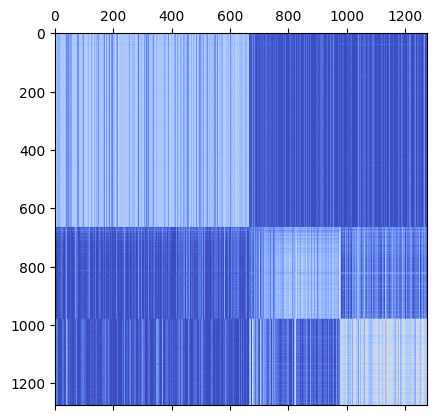

In [43]:
import os

output_dir = './our_dataset/' + dataset + '/A_gate_encoder_1'
os.makedirs(output_dir, exist_ok=True)

for fold in range(folds):
    for i in range(network_num):
        file_path = os.path.join(output_dir, f'A_{fold + 1}_{i + 1}.npy')
        np.save(file_path, res[fold][i].detach().numpy())

plt.matshow(rds[0][0].detach().numpy(), cmap=plt.cm.coolwarm, vmin=0, vmax=1)